C:\Users\toho2\AppData\Local\Temp\ipykernel_33444\3493997728.py:99: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_complete_years_to_present)


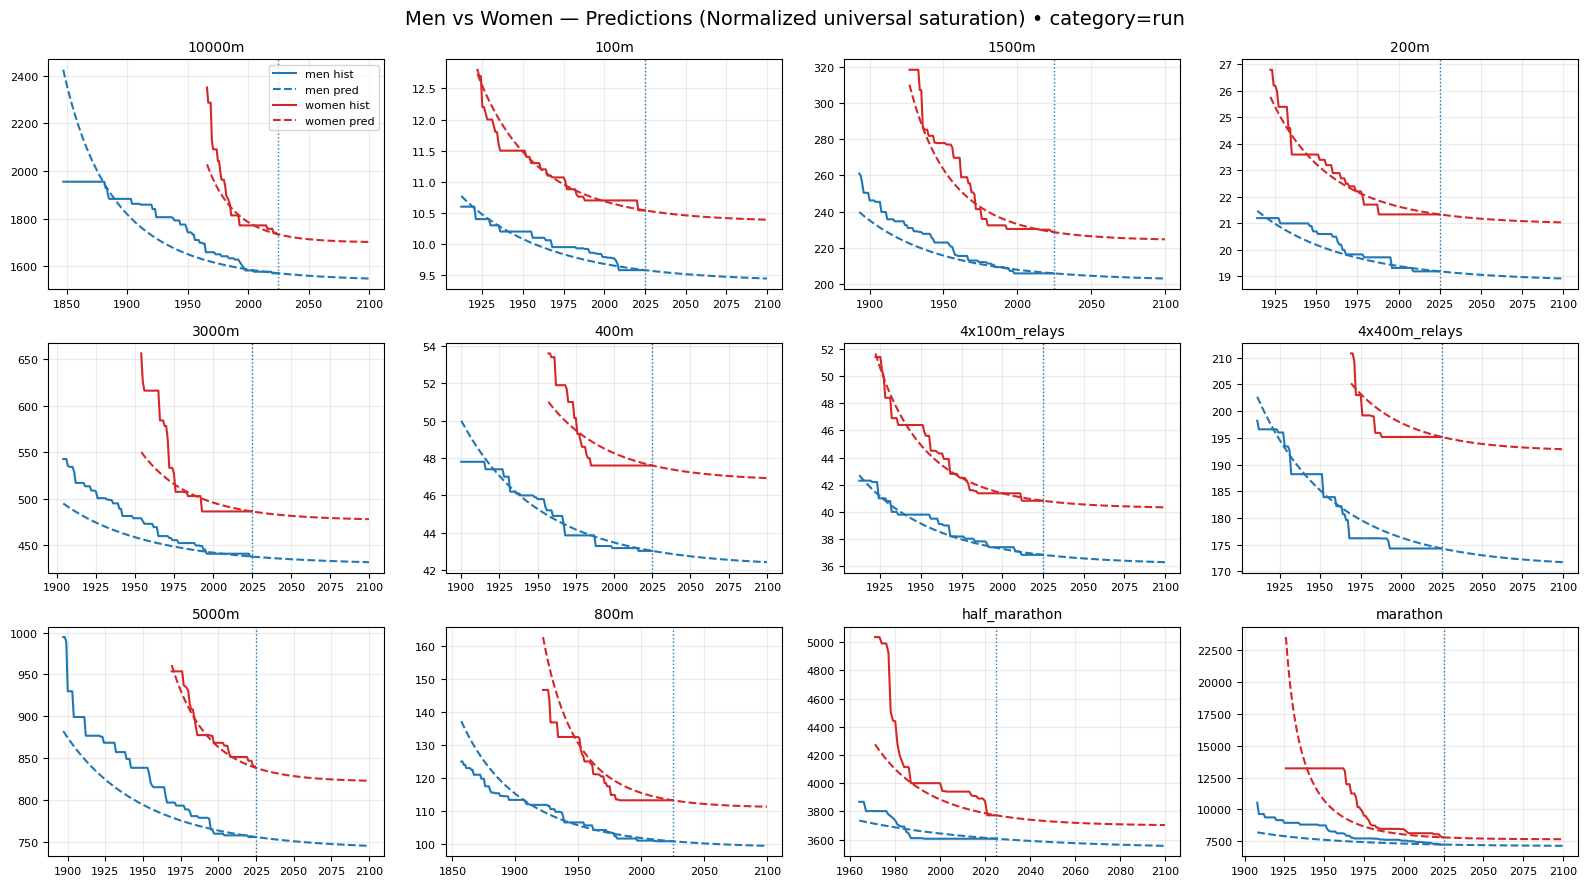

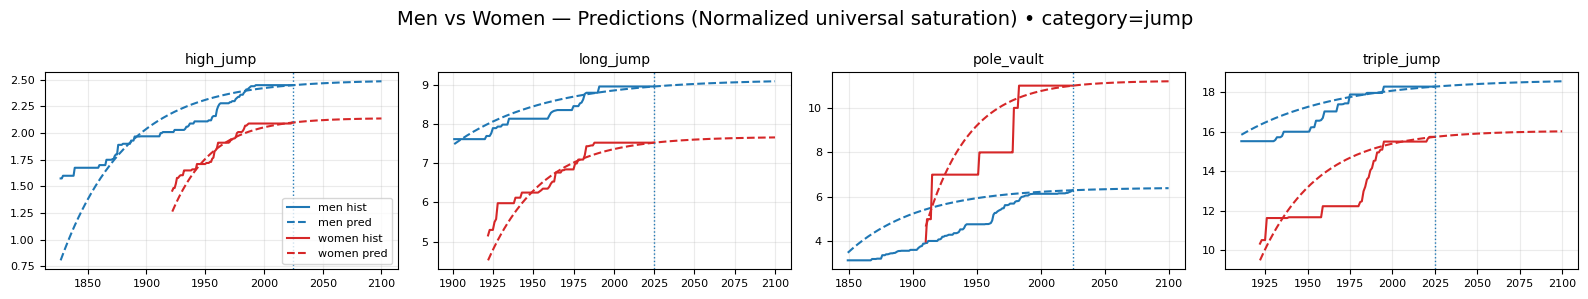

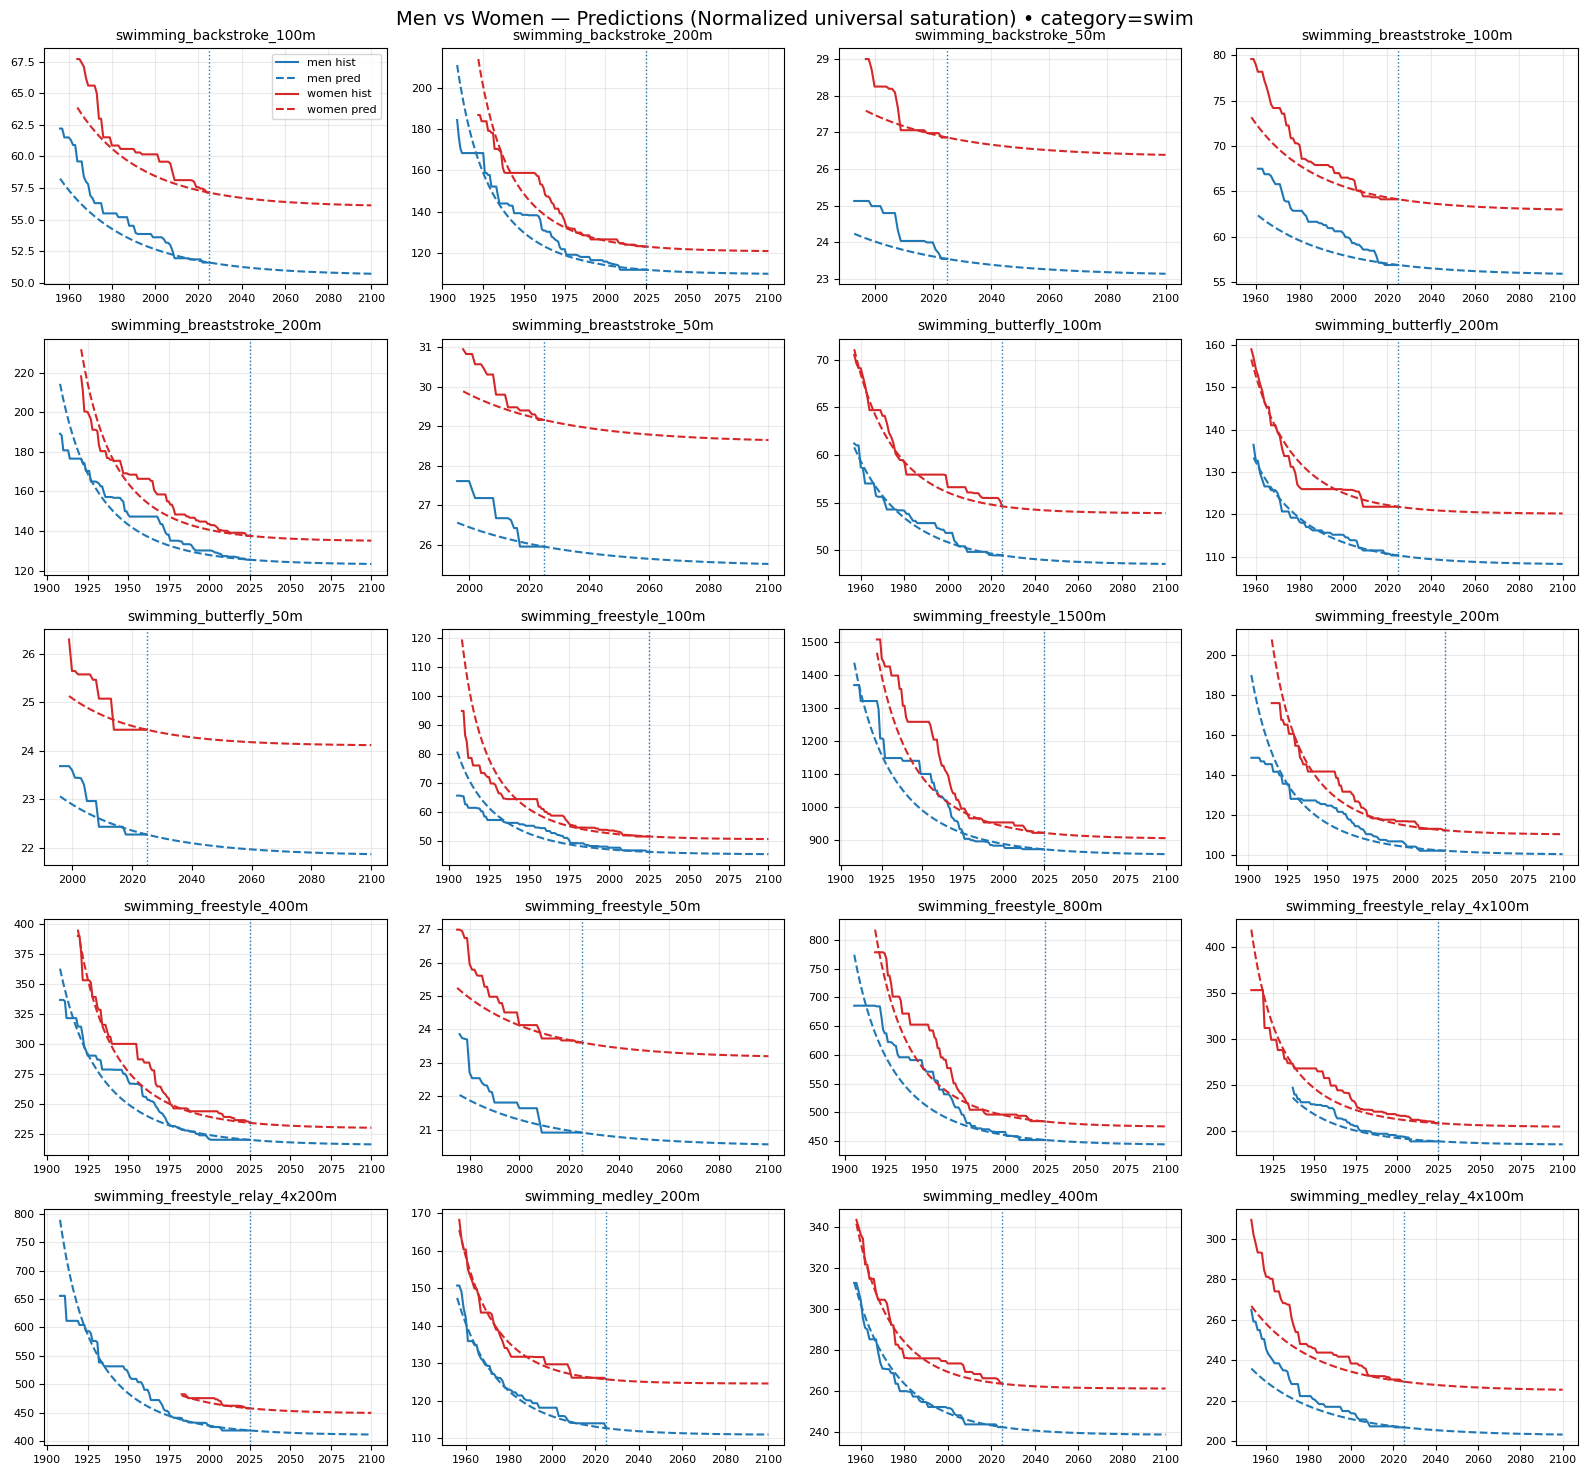

In [56]:
# ===========================================
# 0) Imports
# ===========================================
from pathlib import Path
import numpy as np
import pandas as pd

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import math

# ===========================================
# 1) Reading the file
# ===========================================
# Project root = parent directory of notebooks/
PROJECT_ROOT = Path().resolve().parent

# Data directories
DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

# Input file: cleaned all events results
input_path = DATA_PROCESSED / "all_events_results_clean.csv"

# "Present year" for your thesis context
CURRENT_YEAR = 2025
YEAR_END = 2100

df_raw = pd.read_csv(input_path, parse_dates=["date"])

# Basic schema check
required_cols = [
    "event","sex","measure","date",
    "time_seconds","mark_meters",
    "category","subcategory"
]
missing = [c for c in required_cols if c not in df_raw.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# ===========================================
# 2) Necessary changes / preparation
#    - build annual best-so-far per (event, sex)
#    - extend flat to CURRENT_YEAR
#    - create unified performance where higher=better
# ===========================================
df = df_raw.copy()
df["year"] = df["date"].dt.year

# Keep rows with valid numeric measurement
time_mask = (df["measure"] == "time") & df["time_seconds"].notna()
mark_mask = (df["measure"] == "mark") & df["mark_meters"].notna()
df = df[time_mask | mark_mask].copy()

# Unify performance: higher is better
# time -> performance = 1 / seconds
# mark -> performance = meters
df["performance"] = np.where(
    df["measure"] == "time",
    1.0 / df["time_seconds"].astype(float),
    df["mark_meters"].astype(float)
)

# Annual best performance per (event, sex, year)
annual_best = (
    df.groupby(["event","sex","measure","year"], as_index=False)
      .agg(
          performance=("performance","max"),
          category=("category","first"),
          subcategory=("subcategory","first"),
      )
    .sort_values(["event","sex","year"])
)

# Best-so-far record curve (monotonic non-decreasing in performance)
annual_best["perf_best_so_far"] = (
    annual_best.groupby(["event","sex"])["performance"].cummax()
)

# Extend each (event, sex) to a complete year grid up to CURRENT_YEAR
def _complete_years_to_present(g: pd.DataFrame) -> pd.DataFrame:
    min_y = int(g["year"].min())
    max_y = max(int(g["year"].max()), CURRENT_YEAR)
    years = pd.Index(range(min_y, max_y + 1), name="year")

    g2 = g.set_index("year").reindex(years).reset_index()

    # Fill identifiers/constants
    for col in ["event","sex","measure","category","subcategory"]:
        g2[col] = g[col].iloc[0]

    # Carry forward record
    g2["perf_best_so_far"] = g2["perf_best_so_far"].ffill().bfill()

    return g2

record_curve = (
    annual_best.groupby(["event","sex"], group_keys=False)
              .apply(_complete_years_to_present)
              .reset_index(drop=True)
)

# Keep a clean metadata table (constant per event/sex)
event_meta = (
    record_curve.groupby(["event","sex"], as_index=False)
               .agg(
                   measure=("measure","first"),
                   category=("category","first"),
                   subcategory=("subcategory","first")
               )
)

# Optional: drop very short series
min_points = 10
counts = record_curve.groupby(["event","sex"]).size().reset_index(name="n")
valid_pairs = counts[counts["n"] >= min_points][["event","sex"]]
record_curve = record_curve.merge(valid_pairs, on=["event","sex"], how="inner")

# ===========================================
# 3) Near-ceiling normalized universal saturation model
#    (pooled within category/subcategory/sex)
# ===========================================
rc = record_curve.copy()
rc["t_to_present"] = (CURRENT_YEAR - rc["year"]).astype(int)

# Current (2025) best per event/sex
perf_current = (
    rc[rc["year"] == CURRENT_YEAR]
    .groupby(["event", "sex"], as_index=False)
    .agg(perf_current=("perf_best_so_far", "max"))
)
rc = rc.merge(perf_current, on=["event", "sex"], how="left")

if rc["perf_current"].isna().any():
    missing_pairs = rc.loc[rc["perf_current"].isna(), ["event","sex"]].drop_duplicates()
    raise ValueError(f"Missing perf_current for some pairs:\n{missing_pairs}")

# Normalized performance ratio (<=1 in the past, =1 at 2025)
rc["p_norm"] = rc["perf_best_so_far"] / rc["perf_current"]
rc = rc[rc["p_norm"].between(0.05, 1.05)].copy()  # sanity filter

# Model: p_norm(t) = 1 + rho - rho*exp(beta*t_to_present)
def pnorm_model(t, rho, beta):
    return 1.0 + rho - rho * np.exp(beta * t)

fits = {}

# Choose reasonable headroom bounds (adjust if you want)
# rho = 0.002 means +0.2% performance max (time improves ~0.2%)
RHO_MAX = 0.02   # +2% performance max
BETA_MAX = 0.05  # keep curve gentle; prevents crazy exponentials

for (cat, subcat, sex), g in rc.groupby(["category", "subcategory", "sex"]):
    x = g["t_to_present"].to_numpy(float)
    y = g["p_norm"].to_numpy(float)

    if len(g) < 80:
        continue

    # Start near tiny headroom
    p0 = [0.005, 0.01]  # rho=0.5%, beta small

    try:
        popt, _ = curve_fit(
            pnorm_model,
            x, y,
            p0=p0,
            bounds=([0.0, 0.0], [RHO_MAX, BETA_MAX]),
            maxfev=200_000
        )
        fits[(cat, subcat, sex)] = popt
    except Exception:
        continue

def predict_event_sex(g: pd.DataFrame, rho: float, beta: float, year_end: int = YEAR_END) -> pd.DataFrame:
    event = g["event"].iloc[0]
    sex = g["sex"].iloc[0]
    measure = g["measure"].iloc[0]
    category = g["category"].iloc[0]
    subcategory = g["subcategory"].iloc[0]
    perf_curr = float(g["perf_current"].iloc[0])

    years = np.arange(int(g["year"].min()), year_end + 1)
    t = (CURRENT_YEAR - years).astype(float)  # can be negative in future

    p_pred = pnorm_model(t, rho, beta)

    # Safety: keep within plausible range
    p_pred = np.clip(p_pred, 0.2, 1.0 + rho)

    perf_pred = p_pred * perf_curr

    out = pd.DataFrame({
        "event": event,
        "sex": sex,
        "measure": measure,
        "category": category,
        "subcategory": subcategory,
        "year": years,
        "perf_pred": perf_pred,
        "p_pred": p_pred,
        "rho": rho,
        "beta": beta,
        "model": "normalized_near_ceiling"
    })

    # Convert to native units for plotting
    if measure == "time":
        out["y_pred"] = 1.0 / out["perf_pred"]
    else:
        out["y_pred"] = out["perf_pred"]

    return out

preds_list = []
for (event, sex), g in rc.groupby(["event", "sex"]):
    key = (g["category"].iloc[0], g["subcategory"].iloc[0], sex)
    if key not in fits:
        continue
    rho, beta = fits[key]
    preds_list.append(predict_event_sex(g, rho, beta))

preds = pd.concat(preds_list, ignore_index=True)

# ===========================================
# 4) Build plot_df robustly (metadata not by year!)
# ===========================================
hist = record_curve[["event","sex","year","perf_best_so_far"]].copy()

plot_df = preds.merge(hist, on=["event","sex","year"], how="left")

plot_df["y_hist"] = np.where(
    plot_df["measure"] == "time",
    1.0 / plot_df["perf_best_so_far"],
    plot_df["perf_best_so_far"]
)


# ===========================================
# 4) Plot grid: each subplot = one event
#    with men + women together
# ===========================================

def plot_grid_men_women(
    plot_df: pd.DataFrame,
    category: str | None = None,
    subcategory: str | None = None,
    year_split: int = CURRENT_YEAR,
    max_events: int = 24,
    ncols: int = 4,
    invert_time_axis: bool = True,
):
    d = plot_df.copy()
    if category is not None:
        d = d[d["category"] == category]
    if subcategory is not None:
        d = d[d["subcategory"] == subcategory]

    events = sorted(d["event"].unique())
    if not events:
        print("No events to plot for the selected filters.")
        return

    events = events[:max_events]
    n = len(events)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(4*ncols, 3*nrows),
        squeeze=False
    )
    axes = axes.flatten()

    for i, event in enumerate(events):
        ax = axes[i]
        g = d[d["event"] == event].sort_values("year")
        if g.empty:
            ax.axis("off")
            continue

        measure = g["measure"].iloc[0]

        for sex, color in [("men", "tab:blue"), ("women", "tab:red")]:
            gs = g[g["sex"] == sex].sort_values("year")
            if gs.empty:
                continue

            # Historical (solid)
            gh = gs[gs["y_hist"].notna()]
            if not gh.empty:
                ax.plot(gh["year"], gh["y_hist"], color=color, linewidth=1.5, label=f"{sex} hist")

            # Prediction (dashed)
            ax.plot(gs["year"], gs["y_pred"], color=color, linestyle="--", linewidth=1.5, label=f"{sex} pred")

        ax.axvline(year_split, linestyle=":", linewidth=1)
        ax.set_title(event, fontsize=10)
        ax.grid(True, alpha=0.25)
        ax.tick_params(labelsize=8)

        if measure == "time" and invert_time_axis:
            ax.invert_yaxis()

        # Reduce legend clutter: show only in first subplot
        if i == 0:
            ax.legend(fontsize=8)
        else:
            ax.legend().remove()

    # Turn off extra axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    title = "Men vs Women — Predictions (Normalized universal saturation)"
    if category:
        title += f" • category={category}"
    if subcategory:
        title += f" • subcategory={subcategory}"

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Example usage:
#  - All running events (first 24)
plot_grid_men_women(plot_df, category="run", max_events=50, invert_time_axis=False)

#  - Sprint only (first 24)
# plot_grid_men_women(plot_df, category="run", subcategory="sprint", max_events=24)

#  - Jumps
plot_grid_men_women(plot_df, category="jump", max_events=50, invert_time_axis=False)

#  - Swim: freestyle
plot_grid_men_women(plot_df, category="swim", max_events=50, invert_time_axis=False)


### Old code

In [12]:
### Prepare data for prediction

import numpy as np
import pandas as pd

from pathlib import Path

# Project root = parent directory of notebooks/
PROJECT_ROOT = Path().resolve().parent

# Data directories
DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

# Input file: cleaned all events results
input_path = DATA_PROCESSED / "all_events_results_clean.csv"

# 2025 is the "current year" for the purpose of extending the record curves
CURRENT_YEAR = 2025 

# Load
df_combined = pd.read_csv(input_path, parse_dates=["date"])

# Ensure expected columns exist
required_cols = [
    "event", "sex", "measure", "date",
    "time_seconds", "mark_meters",
    "category", "subcategory"
]
missing = [c for c in required_cols if c not in df_combined.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

In [13]:
# Create year + performance (higher = better)
df = df_combined.copy()
df["year"] = df["date"].dt.year

# Keep only rows with a valid measurement
# time events -> need time_seconds
# mark events -> need mark_meters
time_mask = (df["measure"] == "time") & df["time_seconds"].notna()
mark_mask = (df["measure"] == "mark") & df["mark_meters"].notna()
df = df[time_mask | mark_mask].copy()


# Convert to a unified metric: performance (higher = better)
# - time: use speed proxy = 1 / time_seconds
# - mark: use meters as-is
df["performance"] = np.where(
    df["measure"] == "time",
    1.0 / df["time_seconds"].astype(float),
    df["mark_meters"].astype(float)
)


# Annual "best record so far" series per (event, sex)

# Step 1: within each year take the best performance (max = best)
annual_best = (
    df.groupby(["event", "sex", "measure", "year"], as_index=False)
      .agg(
          performance=("performance", "max"),
          # keep some metadata for the best of the year if you want
          category=("category", "first"),
          subcategory=("subcategory", "first"),
      )
)

# Step 2: make it a cumulative best-so-far curve over years (monotonic non-decreasing)
annual_best = annual_best.sort_values(["event", "sex", "year"])
annual_best["perf_best_so_far"] = (
    annual_best.groupby(["event", "sex"])["performance"]
               .cummax()
)

# Step 3: reindex to a complete year grid per (event, sex)
# and forward-fill the best-so-far value (flat years) until CURRENT_YEAR
def _complete_years_to_present(g: pd.DataFrame) -> pd.DataFrame:
    min_y = int(g["year"].min())
    max_y = max(int(g["year"].max()), CURRENT_YEAR)

    years = pd.Index(range(min_y, max_y + 1), name="year")
    g2 = g.set_index("year").reindex(years).reset_index()

    # Fill identifiers
    for col in ["event", "sex", "measure", "category", "subcategory"]:
        g2[col] = g[col].iloc[0]

    # Forward-fill the best-so-far record through CURRENT_YEAR
    g2["perf_best_so_far"] = g2["perf_best_so_far"].ffill().bfill()

    return g2

record_curve = (
    annual_best.groupby(["event", "sex"], group_keys=False)
               .apply(_complete_years_to_present)
               .reset_index(drop=True)
)

# Add "t" = years since first record year (per event/sex), useful for fitting
first_year = (
    record_curve.groupby(["event", "sex"], as_index=False)["year"]
                .min()
                .rename(columns={"year": "first_year"})
)
record_curve = record_curve.merge(first_year, on=["event", "sex"], how="left")
record_curve["t"] = record_curve["year"] - record_curve["first_year"]

# Optional: drop very short series (curve fitting needs some points)
min_points = 10
counts = record_curve.groupby(["event", "sex"]).size().reset_index(name="n")
valid_pairs = counts[counts["n"] >= min_points][["event", "sex"]]
record_curve = record_curve.merge(valid_pairs, on=["event", "sex"], how="inner")

record_curve["t_to_present"] = CURRENT_YEAR - record_curve["year"]   # 0 at 2025, positive in the past

record_curve.head()


C:\Users\toho2\AppData\Local\Temp\ipykernel_33444\3872442952.py:63: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_complete_years_to_present)


,year,event,sex,measure,performance,category,subcategory,perf_best_so_far,first_year,t,t_to_present
0,1847,10000m,men,time,0.000512,run,long,0.000512,1847,0,178
1,1848,10000m,men,time,NaN,run,long,0.000512,1847,1,177
2,1849,10000m,men,time,NaN,run,long,0.000512,1847,2,176
3,1850,10000m,men,time,NaN,run,long,0.000512,1847,3,175
4,1851,10000m,men,time,NaN,run,long,0.000512,1847,4,174


In [14]:
record_curve

,year,event,sex,measure,performance,category,subcategory,perf_best_so_far,first_year,t,t_to_present
0,1847,10000m,men,time,0.000512,run,long,0.000512,1847,0,178
1,1848,10000m,men,time,NaN,run,long,0.000512,1847,1,177
2,1849,10000m,men,time,NaN,run,long,0.000512,1847,2,176
3,1850,10000m,men,time,NaN,run,long,0.000512,1847,3,175
4,1851,10000m,men,time,NaN,run,long,0.000512,1847,4,174
...,...,...,...,...,...,...,...,...,...,...,...
6711,2021,triple_jump,women,mark,15.670000,jump,jump,15.670000,1922,99,4
6712,2022,triple_jump,women,mark,15.740000,jump,jump,15.740000,1922,100,3
6713,2023,triple_jump,women,mark,NaN,jump,jump,15.740000,1922,101,2
6714,2024,triple_jump,women,mark,NaN,jump,jump,15.740000,1922,102,1


### TEST 0: baseline asymptotic model per (event, sex)

It doesn't stagnate as much as it should, and the results are not realistic

In [ ]:
### Apply the baseline asymptotic model per (event, sex)

from scipy.optimize import curve_fit

def exp_saturation(t, L, a, b):
    # L - a * exp(-b t)
    return L - a * np.exp(-b * t)

def fit_and_forecast_one(group: pd.DataFrame, year_end: int = 2100) -> pd.DataFrame:
    g = group.sort_values("year").copy()

    # x/y for fitting
    x = g["t"].to_numpy(dtype=float)
    y = g["perf_best_so_far"].to_numpy(dtype=float)

    # Guardrails for fitting
    # y must be positive (it is by construction)
    y_max = float(np.nanmax(y))
    y_min = float(np.nanmin(y))

    # Initial guesses:
    # L slightly above last observed best (so model has room to plateau)
    L0 = y_max * 1.02
    a0 = max(L0 - y_min, 1e-12)
    b0 = 0.03  # mild convergence speed

    # Bounds: L must be >= current max; a positive; b positive
    lower = [y_max, 1e-12, 1e-6]
    upper = [y_max * 10.0, (y_max - y_min) * 100.0 + 1e-6, 5.0]

    try:
        popt, pcov = curve_fit(
            exp_saturation,
            x, y,
            p0=[L0, a0, b0],
            bounds=(lower, upper),
            maxfev=50_000
        )
        L_hat, a_hat, b_hat = popt
        fit_ok = True
    except Exception:
        # Fallback: no fit; carry-forward last value flat to 2100
        L_hat, a_hat, b_hat = np.nan, np.nan, np.nan
        fit_ok = False

    # Forecast horizon (year grid)
    first_year = int(g["first_year"].iloc[0])
    years = np.arange(first_year, year_end + 1)
    t_future = years - first_year

    if fit_ok:
        perf_pred = exp_saturation(t_future.astype(float), L_hat, a_hat, b_hat)
        # Keep monotonic non-decreasing as a sanity constraint
        perf_pred = np.maximum.accumulate(perf_pred)
    else:
        perf_pred = np.full_like(years, fill_value=y_max, dtype=float)

    out = pd.DataFrame({
        "event": g["event"].iloc[0],
        "sex": g["sex"].iloc[0],
        "measure": g["measure"].iloc[0],
        "category": g["category"].iloc[0],
        "subcategory": g["subcategory"].iloc[0],
        "year": years,
        "t": t_future,
        "model": "exp_saturation",
        "perf_pred": perf_pred,
        "L_hat": L_hat,
        "a_hat": a_hat,
        "b_hat": b_hat,
        "fit_ok": fit_ok
    })

    # Convert back to predicted time_seconds or mark_meters for user-facing charts
    if out["measure"].iloc[0] == "time":
        # performance = 1 / time_seconds
        out["time_seconds_pred"] = 1.0 / out["perf_pred"]
        out["mark_meters_pred"] = np.nan
    else:
        out["mark_meters_pred"] = out["perf_pred"]
        out["time_seconds_pred"] = np.nan

    return out

# Run for all event/sex pairs
forecasts = (
    record_curve.groupby(["event", "sex"], group_keys=False)
                .apply(fit_and_forecast_one, year_end=2100)
                .reset_index(drop=True)
)

forecasts.head()


In [ ]:
### Join predictions back with history for plotting

history_for_plot = record_curve.rename(columns={"perf_best_so_far": "perf_hist"})[
    ["event", "sex", "measure", "category", "subcategory", "year", "t", "perf_hist"]
]

plot_df = forecasts.merge(
    history_for_plot,
    on=["event", "sex", "measure", "category", "subcategory", "year", "t"],
    how="left"
)

# Convert historical performancw back to time/mark for display
plot_df["time_seconds_hist"] = np.where(
    plot_df["measure"] == "time",
    1.0 / plot_df["perf_hist"],
    np.nan
)
plot_df["mark_meters_hist"] = np.where(
    plot_df["measure"] == "mark",
    plot_df["perf_hist"],
    np.nan
)

# A single "y" for plotting in native units
plot_df["y_hist"] = np.where(
    plot_df["measure"] == "time",
    plot_df["time_seconds_hist"],
    plot_df["mark_meters_hist"]
)
plot_df["y_pred"] = np.where(
    plot_df["measure"] == "time",
    plot_df["time_seconds_pred"],
    plot_df["mark_meters_pred"]
)

plot_df.head(20)


In [ ]:
### Plot one event (both sexes on same chart)

import matplotlib.pyplot as plt

def plot_event_predictions(
    plot_df: pd.DataFrame,
    event: str,
    model: str = "exp_saturation",
    year_split: int = 2025,
    invert_time_axis: bool = True,
    show: bool = True,
):
    d = plot_df[(plot_df["event"] == event) & (plot_df["model"] == model)].copy()
    if d.empty:
        print(f"[skip] No data for event={event}, model={model}")
        return

    measure = d["measure"].iloc[0]
    category = d["category"].iloc[0]
    subcategory = d["subcategory"].iloc[0]

    fig, ax = plt.subplots(figsize=(10, 5))

    for sex in ["women", "men"]:
        g = d[d["sex"] == sex].sort_values("year")
        if g.empty:
            continue

        # Historical points/line (only where available)
        gh = g[g["y_hist"].notna()]
        if not gh.empty:
            ax.plot(gh["year"], gh["y_hist"], linewidth=2, label=f"{sex} (hist)")

        # Prediction line
        ax.plot(g["year"], g["y_pred"], linewidth=2, linestyle="--", label=f"{sex} (pred)")

    ax.axvline(year_split, linestyle=":", linewidth=1)
    ax.set_title(f"{event} • {measure} • {category}/{subcategory} • model={model}")
    ax.set_xlabel("Year")

    if measure == "time":
        ax.set_ylabel("Time (seconds)")
        if invert_time_axis:
            ax.invert_yaxis()  # lower times (better) appear "higher" visually
    else:
        ax.set_ylabel("Mark (meters)")

    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()

    if show:
        plt.show()
    return fig, ax


plot_event_predictions(plot_df, event="high_jump")
plot_event_predictions(plot_df, event="10000m", invert_time_axis=True)


In [ ]:
import math
import matplotlib.pyplot as plt

def plot_grid_predictions(
    plot_df: pd.DataFrame,
    category: str | None = None,
    subcategory: str | None = None,
    sex: str = "women",
    model: str = "exp_saturation",
    year_split: int = 2025,
    max_events: int = 24,
    ncols: int = 4,
    invert_time_axis: bool = True,
):
    d = plot_df[(plot_df["sex"] == sex) & (plot_df["model"] == model)].copy()
    if category is not None:
        d = d[d["category"] == category]
    if subcategory is not None:
        d = d[d["subcategory"] == subcategory]

    events = sorted(d["event"].unique().tolist())
    if not events:
        print("[skip] No events for the selected filters.")
        return

    events = events[:max_events]
    n = len(events)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False)
    axes = axes.flatten()

    for i, event in enumerate(events):
        ax = axes[i]
        g = d[d["event"] == event].sort_values("year")
        if g.empty:
            ax.axis("off")
            continue

        measure = g["measure"].iloc[0]

        gh = g[g["y_hist"].notna()]
        if not gh.empty:
            ax.plot(gh["year"], gh["y_hist"], linewidth=1.5)

        ax.plot(g["year"], g["y_pred"], linewidth=1.5, linestyle="--")
        ax.axvline(year_split, linestyle=":", linewidth=1)

        ax.set_title(event, fontsize=10)
        ax.grid(True, alpha=0.2)

        if measure == "time" and invert_time_axis:
            ax.invert_yaxis()

        # Reduce clutter
        ax.tick_params(labelsize=8)

    # Turn off extra axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    title_bits = [f"sex={sex}", f"model={model}"]
    if category: title_bits.append(f"category={category}")
    if subcategory: title_bits.append(f"subcategory={subcategory}")
    fig.suptitle(" • ".join(title_bits), fontsize=12)

    plt.tight_layout()
    plt.show()
    return fig

# Scan all women's running events (first 24)
plot_grid_predictions(plot_df, category="run", sex="women", max_events=24)

# Scan men's sprint events
plot_grid_predictions(plot_df, category="run", subcategory="sprint", sex="men", max_events=24)

# Scan jump events (women)
plot_grid_predictions(plot_df, category="swim", sex="women", max_events=24, invert_time_axis=False)



In [ ]:
events = sorted(plot_df["event"].unique())
for ev in events:
    plot_event_predictions(plot_df, event=ev, year_split=2025, invert_time_axis=True)



### TEST 1: Normalized universal saturation model (pooled ceiling)

In [45]:
# Prepare normalized data

df = record_curve.copy()

current_best = (
    df[df["year"] == CURRENT_YEAR]
    .groupby(["event", "sex"], as_index=False)
    .agg(perf_current=("perf_best_so_far", "max"))
)

df = df.merge(current_best, on=["event", "sex"], how="left")

# Normalized progress
df["p_norm"] = df["perf_best_so_far"] / df["perf_current"]
df["delta"] = 1.0 - df["p_norm"]

# Safety
df = df[df["delta"] >= 0]



In [46]:
### Fit a shared decay model (per category / subcategory)

from scipy.optimize import curve_fit
import numpy as np

def decay(t, alpha, beta):
    return alpha * np.exp(-beta * t)

fits = {}

for (cat, subcat, sex), g in df.groupby(["category", "subcategory", "sex"]):
    x = g["t"].values
    y = g["delta"].values

    if len(g) < 20:
        continue

    try:
        popt, _ = curve_fit(
            decay,
            x, y,
            p0=[0.5, 0.03],
            bounds=([0, 0], [1, 1]),
            maxfev=20_000
        )
        fits[(cat, subcat, sex)] = popt
    except Exception:
        continue



In [47]:
### Predict to 2100 (realistic stagnation)

def predict_norm_curve(g, alpha, beta, year_end=2100):
    first_year = g["first_year"].iloc[0]
    years = np.arange(first_year, year_end + 1)
    t = years - first_year

    delta_pred = decay(t, alpha, beta)
    p_pred = 1.0 - delta_pred

    perf_pred = p_pred * g["perf_current"].iloc[0]

    return pd.DataFrame({
        "event": g["event"].iloc[0],
        "sex": g["sex"].iloc[0],
        "year": years,
        "perf_pred": perf_pred,
        "model": "normalized_decay"
    })

preds = []

for (event, sex), g in df.groupby(["event", "sex"]):
    key = (g["category"].iloc[0], g["subcategory"].iloc[0], sex)
    if key not in fits:
        continue

    alpha, beta = fits[key]
    preds.append(predict_norm_curve(g, alpha, beta))

preds = pd.concat(preds, ignore_index=True)



In [48]:
### Join predictions back with history for plotting

plot_df = preds.merge(
    record_curve[
        ["event", "sex", "year", "perf_best_so_far", "measure", "category", "subcategory"]
    ],
    on=["event", "sex", "year"],
    how="left"
)

# Convert performance back to native units for plotting
plot_df["y_hist"] = np.where(
    plot_df["measure"] == "time",
    1.0 / plot_df["perf_best_so_far"],
    plot_df["perf_best_so_far"]
)

plot_df["y_pred"] = np.where(
    plot_df["measure"] == "time",
    1.0 / plot_df["perf_pred"],
    plot_df["perf_pred"]
)

bad = plot_df[(plot_df["measure"] == "time") & (plot_df["y_pred"] < 1)]
bad[["event","sex","year","y_pred"]].head(20)


,event,sex,year,y_pred


In [50]:
plot_df[(plot_df['event'] == '100m') & (plot_df['sex'] == 'women')].head(107)

,event,sex,year,perf_pred,model,perf_best_so_far,measure,category,subcategory,y_hist,y_pred
578,100m,women,1922,0.079812,normalized_decay,0.078125,time,run,sprint,12.80,12.529453
579,100m,women,1923,0.080348,normalized_decay,0.078740,time,run,sprint,12.70,12.445902
580,100m,women,1924,0.080864,normalized_decay,0.078740,time,run,sprint,12.70,12.366371
581,100m,women,1925,0.081363,normalized_decay,0.081967,time,run,sprint,12.20,12.290625
582,100m,women,1926,0.081843,normalized_decay,0.081967,time,run,sprint,12.20,12.218447
...,...,...,...,...,...,...,...,...,...,...,...
680,100m,women,2024,0.094502,normalized_decay,0.094877,time,run,sprint,10.54,10.581798
681,100m,women,2025,0.094515,normalized_decay,0.094877,time,run,sprint,10.54,10.580306
682,100m,women,2026,0.094528,normalized_decay,NaN,NaN,NaN,NaN,NaN,0.094528
683,100m,women,2027,0.094540,normalized_decay,NaN,NaN,NaN,NaN,NaN,0.094540


In [20]:
### Grid plot function

import math
import matplotlib.pyplot as plt

def plot_prediction_grid(
    plot_df: pd.DataFrame,
    sex: str,
    category: str | None = None,
    subcategory: str | None = None,
    year_split: int = 2025,
    max_events: int = 30,
    ncols: int = 5,
    invert_time_axis: bool = True,
):
    d = plot_df[plot_df["sex"] == sex].copy()

    if category is not None:
        d = d[d["category"] == category]
    if subcategory is not None:
        d = d[d["subcategory"] == subcategory]

    events = sorted(d["event"].unique())
    if not events:
        print("No events to plot.")
        return

    events = events[:max_events]
    n = len(events)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(4 * ncols, 3 * nrows),
        squeeze=False
    )
    axes = axes.flatten()

    for i, event in enumerate(events):
        ax = axes[i]
        g = d[d["event"] == event].sort_values("year")

        # Historical (solid)
        gh = g[g["y_hist"].notna()]
        if not gh.empty:
            ax.plot(
                gh["year"], gh["y_hist"],
                linewidth=1.5,
                color="black"
            )

        # Prediction (dashed)
        ax.plot(
            g["year"], g["y_pred"],
            linewidth=1.5,
            linestyle="--",
            color="tab:blue"
        )

        ax.axvline(year_split, linestyle=":", linewidth=1)
        ax.set_title(event, fontsize=10)
        ax.grid(True, alpha=0.25)

        if g["measure"].iloc[0] == "time" and invert_time_axis:
            ax.invert_yaxis()

        ax.tick_params(labelsize=8)

    # Turn off unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    title = f"Predictions (normalized decay) • sex={sex}"
    if category:
        title += f" • category={category}"
    if subcategory:
        title += f" • subcategory={subcategory}"

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


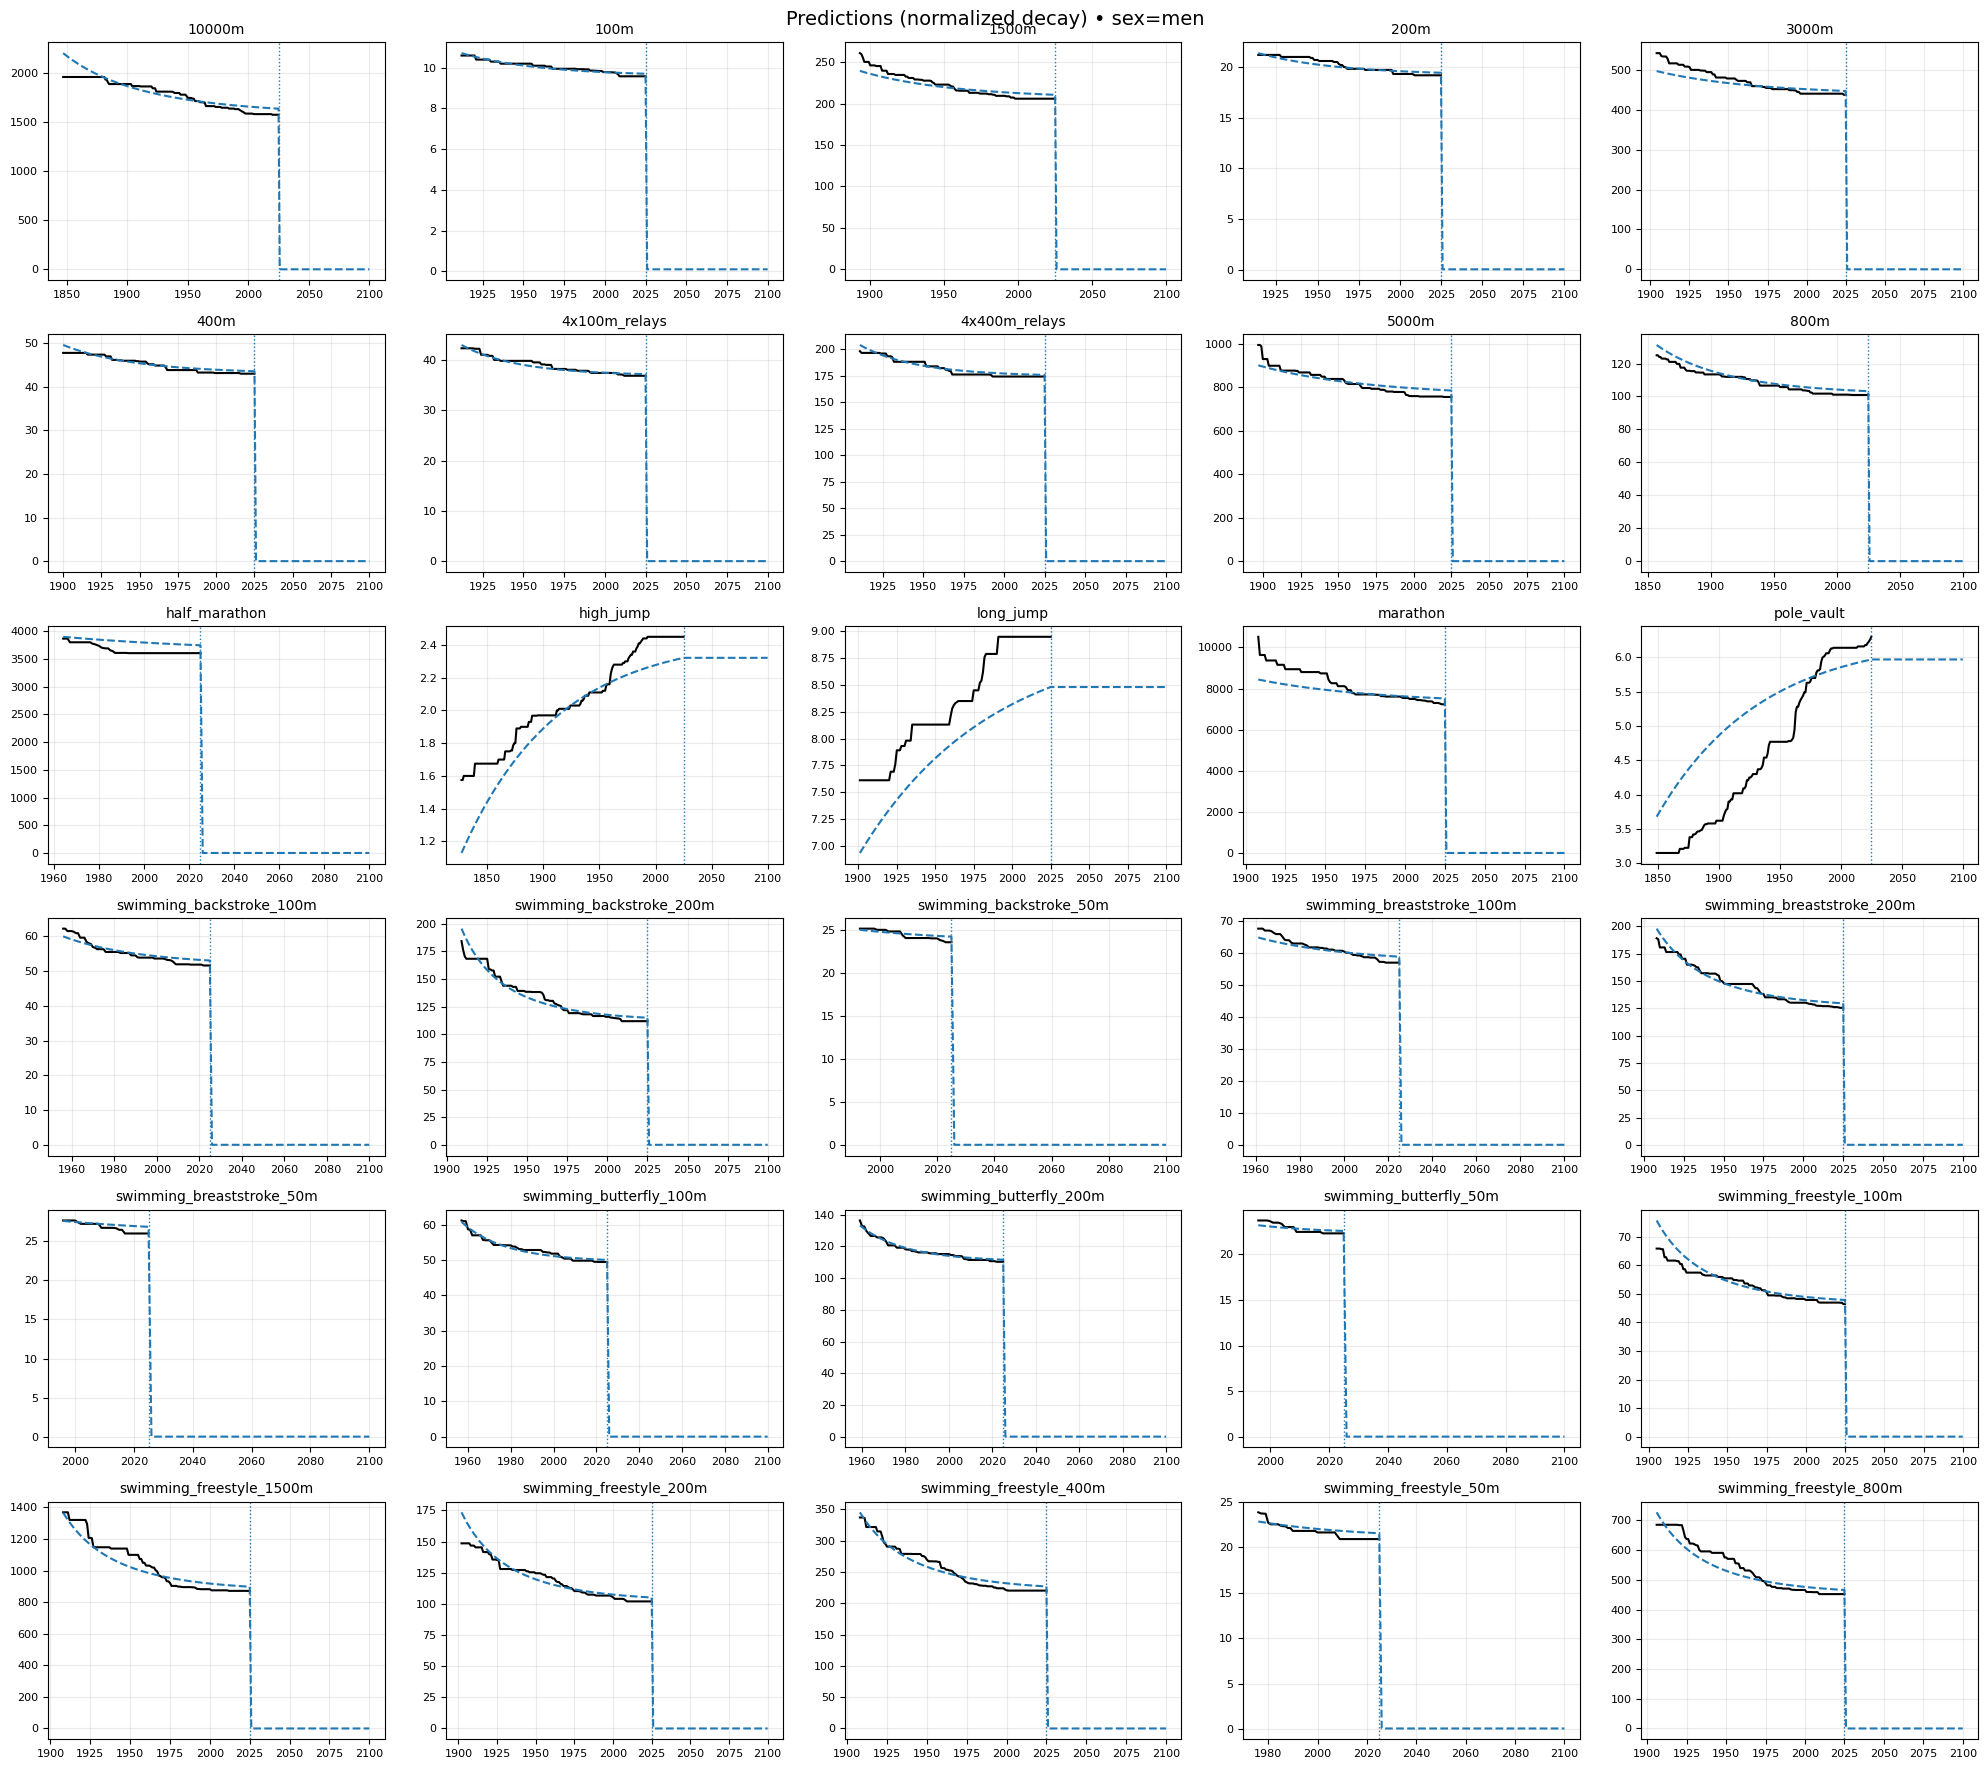

In [24]:
plot_prediction_grid(
    plot_df,
    sex="men",
    invert_time_axis=False
)
